In [1]:
# import
import pandas as pd
import numpy as np
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
import utils

import NN
import os
from torch import load as load_model
import config as cfg

In [2]:
# all data
dia_df = pd.read_csv("data/DIA.csv")
qqq_df = pd.read_csv("data/QQQ.csv")
spy_df = pd.read_csv("data/SPY.csv")

# adding suffix to all df
dia_df.columns=dia_df.columns.map(lambda x : x+'_dia' if x !='Date' else x)
qqq_df.columns=qqq_df.columns.map(lambda x : x+'_qqq' if x !='Date' else x)
spy_df.columns=spy_df.columns.map(lambda x : x+'_spy' if x !='Date' else x)

In [3]:
dfs = [dia_df, qqq_df, spy_df]

df = reduce(lambda left,right: pd.merge(left,right,on='Date'), dfs)

# set date column as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2015-04-13')]
Training_df = df.loc[('2011-01-03' <= df.index) & (df.index <= '2012-12-31')]
Test_df = df.loc[('2013-01-02' <= df.index) & (df.index <= '2013-12-31')]
Out_of_sample_df = df.loc[('2014-01-02' <= df.index) & (df.index <= '2015-04-13')]

# Figure 1

In [4]:
ETF_df = Total_df[['Close_dia', 'Close_qqq', 'Close_spy']].copy()

In [5]:
ETF_df

,Close_dia,Close_qqq,Close_spy
Date,,,
2011-01-03,116.410004,55.310001,127.050003
2011-01-04,116.639999,55.270000,126.980003
2011-01-05,117.040001,55.740002,127.639999
2011-01-06,116.779999,55.919998,127.389999
2011-01-07,116.570000,55.869999,127.139999
...,...,...,...
2015-04-07,178.419998,105.800003,207.279999
2015-04-08,178.750000,106.639999,207.979996
2015-04-09,179.399994,107.309998,208.899994


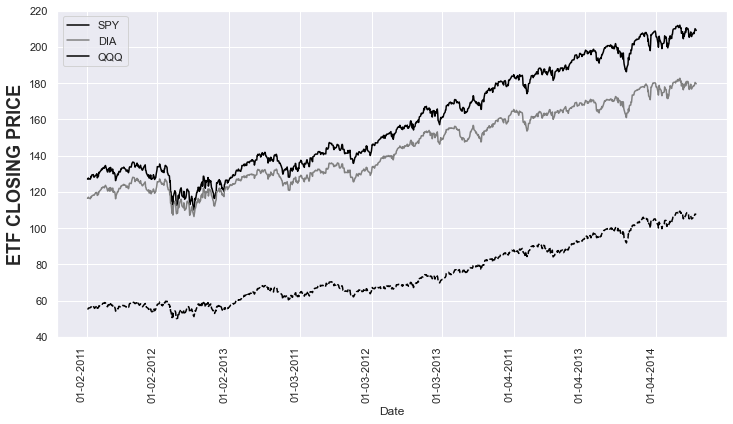

In [6]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))

fig = sns.lineplot(x=ETF_df.index, y='Close_spy', data=ETF_df, label="SPY", color='black')
sns.lineplot(x=ETF_df.index, y='Close_dia', data=ETF_df, label="DIA", color='grey')
sns.lineplot(x=ETF_df.index, y='Close_qqq', data=ETF_df, label="QQQ", color='black')

ax.lines[2].set_linestyle("--")

ax.set_ylabel('ETF CLOSING PRICE', fontsize=18, fontweight='bold')
ax.set(ylim=(40, 220))

x_dates = ETF_df.index.strftime('%d-%m-%Y').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=90, ha='right');

plt.savefig('table/Figure1.png', bbox_inches='tight')

# Table 2

In [7]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()

ADJ_Close_table = pd.DataFrame({'Jarque-Bera stats':Total_adj_close_df.apply(utils.jarque_bera_t_stat),
                                'Jarque-Bera pval':Total_adj_close_df.apply(utils.jarque_bera_p_value),
                                'ADF stats':Total_adj_close_df.apply(utils.adf_t_stat),
                                'ADF pval':Total_adj_close_df.apply(utils.adf_p_value)
                               })

ADJ_Close_table = ADJ_Close_table.transpose()[['Adj Close_spy', 'Adj Close_dia', 'Adj Close_qqq']]
ADJ_Close_table.to_csv("table/ADJ_close_stats.csv", index=True)
ADJ_Close_table
# ADF null hypothesis = unit root 

,Adj Close_spy,Adj Close_dia,Adj Close_qqq
Jarque-Bera stats,95.254220,86.385522,99.153804
Jarque-Bera pval,0.000000,0.000000,0.000000
ADF stats,0.200271,-0.235632,0.313742
ADF pval,0.972277,0.934139,0.977966


In [8]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])

Adj_close_stats_df = Total_adj_close_df.iloc[1:,-3:].copy()
# Adj_close_stats_df

Adj_close_Table = pd.DataFrame({'Mean':Adj_close_stats_df.apply(np.mean),
                                'STD':Adj_close_stats_df.apply(np.std),
                                'Skew':Adj_close_stats_df.apply(skew),
                                'Fisher_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, True)),
                                'Pearson_Kurtosis':Adj_close_stats_df.apply(kurtosis, args=(0, False)),
#                                 'Jarque-Bera_t_stat':Adj_close_stats_df.apply(jarque_bera_t_stat),
                                'Jarque-Bera_p_value':Adj_close_stats_df.apply(utils.jarque_bera_p_value),
#                                 'ADF_t_stat':Adj_close_stats_df.apply(adf_t_stat),
                                'ADF_p_value':Adj_close_stats_df.apply(utils.adf_p_value)})
Table2 = Adj_close_Table.transpose()[['SPY', 'DIA', 'QQQ']]

Table2.to_csv("table/Table2.csv", index=True)
Table2

,SPY,DIA,QQQ
Mean,5.443915e-04,4.971633e-04,6.659312e-04
STD,9.592380e-03,8.863505e-03,1.052343e-02
Skew,-5.687756e-01,-5.178219e-01,-4.048366e-01
Fisher_Kurtosis,5.238305e+00,4.371469e+00,3.177268e+00
Pearson_Kurtosis,8.238305e+00,7.371469e+00,6.177268e+00
Jarque-Bera_p_value,0.000000e+00,0.000000e+00,0.000000e+00
ADF_p_value,6.154752e-30,8.649508e-30,7.087245e-19


In [9]:
# Correlation matrix (Spearman's rank)
Spearman_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="spearman")

Spearman_corr.to_csv("table/Spearman_correlation.csv", index=True)
Spearman_corr

,SPY,DIA,QQQ
SPY,1.000000,0.955254,0.887686
DIA,0.955254,1.000000,0.805231
QQQ,0.887686,0.805231,1.000000


In [10]:
# Correlation matrix (Pearson's method)
Pearson_corr = Adj_close_stats_df[['SPY', 'DIA', 'QQQ']].corr(method="pearson")

Pearson_corr.to_csv("table/Pearson_correlation.csv", index=True)
Pearson_corr

,SPY,DIA,QQQ
SPY,1.000000,0.972872,0.926548
DIA,0.972872,1.000000,0.871434
QQQ,0.926548,0.871434,1.000000


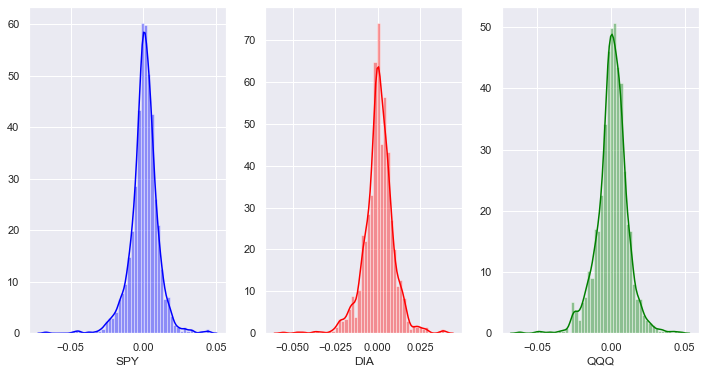

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,6))
sns.distplot(Adj_close_stats_df["SPY"], ax=ax1, color="blue")
sns.distplot(Adj_close_stats_df["DIA"], ax=ax2, color="red")
sns.distplot(Adj_close_stats_df["QQQ"], ax=ax3, color="green")

plt.show()
fig.savefig('table/ReturnsDensityPlot.png', bbox_inches='tight')

# Table 3

In [12]:
# Table 3
datasets = ["Total data-set", "Training data-set", "Test data-set", "Out-of-sample data-set"]
trading_days = [len(Total_df), len(Training_df), len(Test_df), len(Out_of_sample_df)]
start_date = [Total_df.index[0].strftime('%d/%m/%Y'), Training_df.index[0].strftime('%d/%m/%Y'), Test_df.index[0].strftime('%d/%m/%Y'), Out_of_sample_df.index[0].strftime('%d/%m/%Y')]
end_date = [Total_df.index[-1].strftime('%d/%m/%Y'), Training_df.index[-1].strftime('%d/%m/%Y'), Test_df.index[-1].strftime('%d/%m/%Y'), Out_of_sample_df.index[-1].strftime('%d/%m/%Y')]

Table3 = pd.DataFrame({"Datasets":datasets, "Trading days":trading_days, "Start date":start_date, "End date": end_date})

Table3.to_csv("table/Table3.csv", index=False)
Table3

,Datasets,Trading days,Start date,End date
0,Total data-set,1075,03/01/2011,13/04/2015
1,Training data-set,502,03/01/2011,31/12/2012
2,Test data-set,252,02/01/2013,31/12/2013
3,Out-of-sample data-set,321,02/01/2014,13/04/2015


# Table 4

In [4]:
ARMATable4 = pd.read_csv("table/ARMATable4.csv", index_col=["ETF", "Statistic"])
MODELSTable4 = pd.read_csv("table/Table4norm.csv", index_col=["ETF", "Statistic"])
Table4 = ARMATable4.join(MODELSTable4)
Table4.to_csv("table/Table4.csv", index=True)
Table4

ARMA         MLP         RNN           PSN
ETF Statistic                                                  
SPY MAE          0.006499    0.006131    0.006375  8.385928e-03
    MAPE       139.575641  248.302657  228.518788  5.145750e+02
    RMSE         0.008524    0.008047    0.008180  9.820658e-03
    THEIL-U      0.784646    0.706047    0.719330  7.099695e-01
DIA MAE          0.006370    0.006297    0.006523  6.792337e-03
    MAPE       149.321672  237.572144  248.927200  2.972754e+14
    RMSE         0.008462    0.008457    0.008312  8.286969e-03
    THEIL-U      0.764763    0.728351    0.707557  7.240519e-01
QQQ MAE          0.006589    0.007434    0.008304  7.470355e-03
    MAPE       162.776420  231.404451  251.817842  1.897708e+14
    RMSE         0.008522    0.009819    0.010610  9.285087e-03
    THEIL-U      0.758585    0.713580    0.726389  7.581732e-01

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005889 | Test MAPE  : 2.242785 | Test RMSE : 0.007971 | Test Theil-U 0.712896
Sequential(
  (0): Linear(in_features=7, out_features=9, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=9, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006116 | Test MAPE  : 521.733616 | Test RMSE : 0.008149 | Test Theil-U 0.699183
Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=8, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Tes

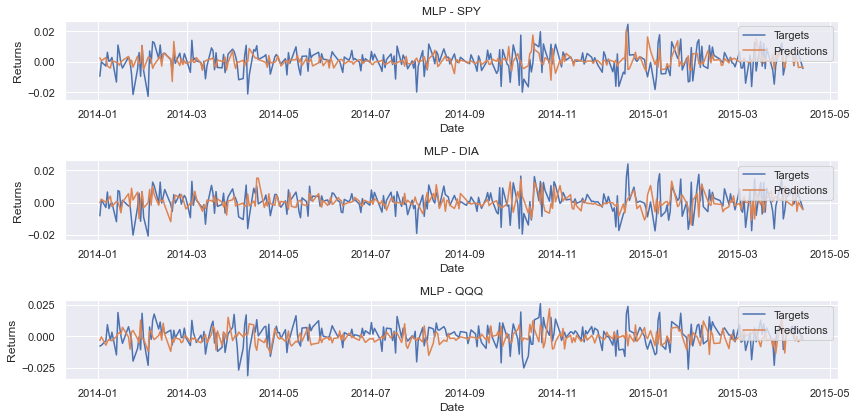

RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.005933 | Test MAPE  : 2.294425 | Test RMSE : 0.007822 | Test Theil-U 0.700378
RNN(
  (rnn): RNN(8, 7)
  (fc): Linear(in_features=7, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.005
    momentum: 0.006
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006806 | Test MAPE  : 109.896183 | Test RMSE : 0.008688 | Test Theil-U 0.775052
RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.007861 | Test MAPE  : 6.156275 | Test RMSE : 0.010512 | Test Theil-U 0.718396


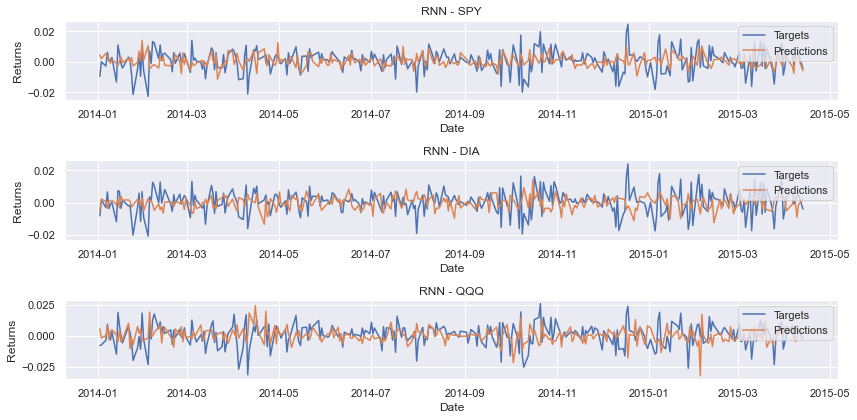

PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.015314 | Test MAPE  : 11.242355 | Test RMSE : 0.017890 | Test Theil-U 0.745585
PSN(
  (fc): Linear(in_features=7, out_features=6, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.012303 | Test MAPE  : 23667.485516 | Test RMSE : 0.014702 | Test Theil-U 0.725522
PSN(
  (fc): Linear(in_features=9, out_features=8, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.3
    momentum: 0.4
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.007204 | Test MAPE  : 28942.789713 | Test RMSE : 0.009479 | Test Theil-U 0.720968


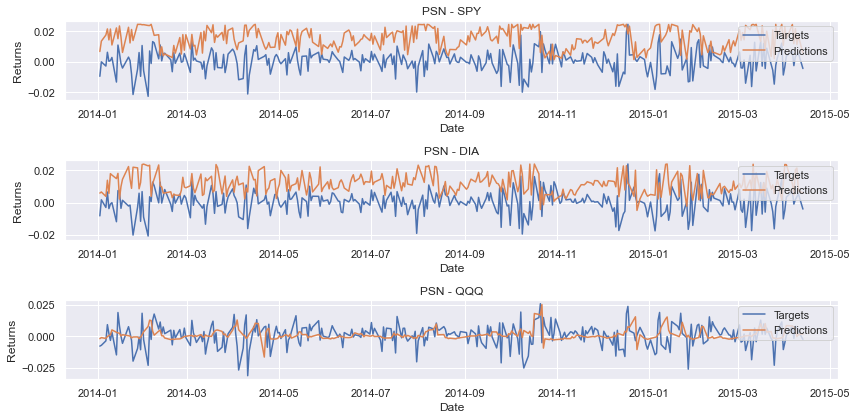

In [9]:
sns.set()
for NNtype in ['MLP', 'RNN', 'PSN']:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))
    for ETF in ['SPY', 'DIA', 'QQQ']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
            AX = ax1 # for the plot
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
            AX = ax2 # for the plot
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
            AX = ax3 # for the plot
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl")) #Test.pkl = Out of sample df
        outOfSampleMu, outOfSampleSigma = df.Return.mean(), df.Return.std()    
        min_, max_ = df.Return.min(), df.Return.max()
        
        if NNtype != "PSN":
            dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=True, mu=outOfSampleMu, sigma=outOfSampleSigma)
        
        else:
            df = (df - min_) / (max_ - min_)
            dataloader  = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)
            
        modelloaded = NN.Model(NNtype)
        epochs = 200 if NNtype == "PSN" else 500
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          epochs,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        
        if NNtype == "PSN":
            modelloaded.evaluate(dataloader, min_=min_, max_=max_)
            preds = modelloaded.predict(dataloader, min_=min_, max_=max_)
            labels = df["Target"]*(max_ - min_) + min_
        else :
            modelloaded.evaluate(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
            preds = modelloaded.predict(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
            labels = np.array(df["Target"].tolist())
        
        predDf = pd.DataFrame({"Predictions":preds, "Targets":labels}, index=df["Target"].index)
        sns.lineplot(x=predDf.index, y='Targets', data=predDf, label="Targets", ax=AX)
        sns.lineplot(x=predDf.index, y='Predictions', data=predDf, label="Predictions", ax=AX)
        AX.set_ylabel('Returns')
        AX.set_title(NNtype + " - " + ETF)
        AX.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    fig.savefig('table/'+ NNtype 'ETFs.png', bbox_inches='tight')

* Problem with the MAPE when the returns are equal to 0

In [13]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])
# test = Total_adj_close_df.copy()

# test.drop(test[(test["DIA"] == 0) | (test["QQQ"] == 0) | (test["SPY"] == 0)].index, inplace=True)

SPY_returns_0 = len(Total_adj_close_df.loc[(Total_adj_close_df["SPY"]==0),:])
QQQ_returns_0 = len(Total_adj_close_df.loc[(Total_adj_close_df["QQQ"]==0),:])
DIA_returns_0 = len(Total_adj_close_df.loc[(Total_adj_close_df["DIA"]==0),:])
total_returns_0 = len(Total_adj_close_df.loc[(Total_adj_close_df["SPY"]==0) | (Total_adj_close_df["QQQ"]==0) | (Total_adj_close_df["DIA"]==0),:])

print("Total days when SPY returns are equal to 0 :", SPY_returns_0)
print("Total days when DIA returns are equal to 0 :", DIA_returns_0)
print("Total days when QQQ returns are equal to 0 :", QQQ_returns_0)
print("Total days when returns are equal to 0 :", total_returns_0)

Total days when SPY returns are equal to 0 : 5
Total days when DIA returns are equal to 0 : 3
Total days when QQQ returns are equal to 0 : 9
Total days when returns are equal to 0 : 17


# Table 5

Pesaran-Timmermann test and Diebold Mariano test

In [4]:
# Pesaran-Timmermann test
#https://purehost.bath.ac.uk/ws/portalfiles/portal/189214729/Forecasting_directional_change.pdf
#https://www.real-statistics.com/time-series-analysis/forecasting-accuracy/pesaran-timmermann-test/
#https://www.economicsnetwork.ac.uk/showcase/cook_directional
#
#
# Diebold Mariano test
# References:
#
# Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of 
#   prediction mean squared errors. International Journal of forecasting, 
#   13(2), 281-291.
#
# Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy, 
#   Journal of business & economic statistics 13(3), 253-264.

In [7]:
Table = pd.DataFrame()
Table_bis = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    TablePT = pd.DataFrame({"Test":"PT", "ETF":[ETF]})
    TableDM = pd.DataFrame({"Test":"DM", "ETF":[ETF]})
    for NNtype in ['MLP', 'RNN']:  
        params = cfg.train_parameters[ETF][NNtype]
        params_PSN = cfg.train_parameters[ETF]["PSN"]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
            inputs_PSN = cfg.SPYfeatures["PSN"]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
            inputs_PSN = cfg.DIAfeatures["PSN"]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
            inputs_PSN = cfg.QQQfeatures["PSN"]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        # Loading ARMA prediction for this ETF
        ARMApredsDf = pd.read_pickle(os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
        ARMApred = ARMApredsDf["Predictions"].to_list()
        
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl")) #Test.pkl = Out of sample df
        outOfSampleMu, outOfSampleSigma = df.Return.mean(), df.Return.std()     
        
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=True, mu=outOfSampleMu, sigma=outOfSampleSigma)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          500,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader, outOfSampleMu, outOfSampleSigma)
            
            
        # Load PSN model to compare with
        features_PSN = []
        for i in inputs_PSN:
            features_PSN.append("Return_" + str(i))

        df_PSN  = utils.load_file(os.path.join("data", ETF, "PSN", "Test.pkl")) #Test.pkl = Out of sample df
        min_, max_ = df_PSN.Return.min(), df_PSN.Return.max()    

        df_PSN = (df_PSN - min_) / (max_ - min_)
        dataloaderPSN = utils.DataFrame2DataLoader(df_PSN, features_PSN, target_col, batch_size=1, normalize=False)
            
        PSNloaded = NN.Model("PSN")
        PSNloaded.setup(params_PSN["input_size"],
                        params_PSN["hidden_size"],
                        params_PSN["output_size"],
                        200,#params_PSN["epochs"],
                        params_PSN["optim"],
                        params_PSN["lr"],
                        params_PSN["momentum"])
        PSNloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, "PSN", "ckpt.pth")))
        PSNloaded.evaluate(dataloaderPSN, min_=min_, max_=max_)
        
        # compare prediction from both model
        PSNpred = PSNloaded.predict(dataloaderPSN, min_=min_, max_=max_)
        pred_lst = modelloaded.predict(dataloader, outOfSampleMu, outOfSampleSigma)
        actual_lst = df['Target'].to_list()
        TableDM[NNtype] = utils.dm_test(actual_lst, PSNpred, pred_lst, h = 1, crit="MSE")[0]

        TablePT[NNtype] = modelloaded.testPT
        TablePT['PSN'] = PSNloaded.testPT
        
        # adding ARMA
        TableDM["ARMA"] = utils.dm_test(actual_lst, PSNpred, ARMApred, h = 1, crit="MSE")[0]
        TablePT['ARMA'] = utils.PT_test(np.array(df['Target'].to_list()), np.array(ARMApred))
        
    Table = pd.concat([Table,TablePT],ignore_index=True)
    Table_bis = pd.concat([Table_bis,TableDM],ignore_index=True)
Table5 = pd.concat([Table,Table_bis],ignore_index=True, sort=False)
Table5.set_index(['Test', 'ETF'], inplace=True)
Table5 = Table5[['ARMA', 'MLP', 'RNN', 'PSN']]
Table5.to_csv("table/Table5.csv", index=True)
Table5

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006160 | Test MAPE  : 2.729589 | Test RMSE : 0.008097 | Test Theil-U 0.711342
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.015634 | Test MAPE  : 11.461998 | Test RMSE : 0.018174 | Test Theil-U 0.747395
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006371 | Test MAPE  : 2.512226 | Test RMSE : 0.008189 | Test Theil-U 0.721020
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=

ARMA        MLP        RNN        PSN
Test ETF                                            
PT   SPY  66.510158  12.530307   5.425501  19.255628
     DIA  41.307231  18.847723   9.801966  16.602262
     QQQ  42.339970   5.111238   1.156279  33.952277
DM   SPY  15.464029  14.585375  13.917103        NaN
     DIA  13.784074  11.536521  12.096834        NaN
     QQQ   3.131371  -1.026648  -3.117165        NaN

In [7]:
## Chay Proposition

Table = pd.DataFrame()
Table_bis = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    TablePT = pd.DataFrame({"Test":"PT", "ETF":[ETF]})
    TableDM = pd.DataFrame({"Test":"DM", "ETF":[ETF]})
    for NNtype in ['MLP', 'RNN']:  
        params = cfg.train_parameters[ETF][NNtype]
        params_PSN = cfg.train_parameters[ETF]["PSN"]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
            inputs_PSN = cfg.SPYfeatures["PSN"]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
            inputs_PSN = cfg.DIAfeatures["PSN"]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
            inputs_PSN = cfg.QQQfeatures["PSN"]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        
        # Loading ARMA prediction for this ETF
        ARMApredsDf = pd.read_pickle(os.path.join("models_norm", ETF, "ARMA", "Predictions.pkl"))
        ARMApred = ARMApredsDf["Predictions"].to_list()
        
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl")) #Test.pkl = Out of sample df
        outOfSampleMu, outOfSampleSigma = df.Return.mean(), df.Return.std()     
        
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=True, mu=outOfSampleMu, sigma=outOfSampleSigma)
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          500,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
            
            
        # Load PSN model to compare with
        features_PSN = []
        for i in inputs_PSN:
            features_PSN.append("Return_" + str(i))
        
        traindf_PSN  = utils.load_file(os.path.join("data", ETF, "PSN", "Train.pkl"))
        df_PSN  = utils.load_file(os.path.join("data", ETF, "PSN", "Test.pkl")) #Test.pkl = Out of sample df
        min_, max_ = traindf_PSN.Return.min(), traindf_PSN.Return.max()    

        df_PSN = (df_PSN - min_) / (max_ - min_)
        dataloaderPSN = utils.DataFrame2DataLoader(df_PSN, features_PSN, target_col, batch_size=1, normalize=False)
            
        PSNloaded = NN.Model("PSN")
        PSNloaded.setup(params_PSN["input_size"],
                        params_PSN["hidden_size"],
                        params_PSN["output_size"],
                        200,#params_PSN["epochs"],
                        params_PSN["optim"],
                        params_PSN["lr"],
                        params_PSN["momentum"])
        PSNloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, "PSN", "ckpt.pth")))
        PSNloaded.evaluate(dataloaderPSN, min_=min_, max_=max_)
        
        # compare prediction from both model
        PSNpred = PSNloaded.predict(dataloaderPSN, min_=min_, max_=max_)
        pred_lst = modelloaded.predict(dataloader, mu=outOfSampleMu, sigma=outOfSampleSigma)
        actual_lst = df['Target'].to_list()
        psn_actual_lst = df_PSN.Target * (max_ - min_) + min_
        TableDM[NNtype] = utils.dm_test(actual_lst, PSNpred, pred_lst, h = 1, crit="MSE")[0]
        
        TablePT[NNtype] = utils.PT_test(np.array(actual_lst), np.array(pred_lst))
        TablePT["PSN"] = utils.PT_test(np.array(psn_actual_lst), np.array(PSNpred))
#         TablePT[NNtype] = modelloaded.testPT
#         TablePT['PSN'] = PSNloaded.testPT
        
        # adding ARMA
        TableDM["ARMA"] = utils.dm_test(actual_lst, PSNpred, ARMApred, h = 1, crit="MSE")[0]
        TablePT['ARMA'] = utils.PT_test(np.array(actual_lst), np.array(ARMApred))
        
    Table = pd.concat([Table,TablePT],ignore_index=True)
    Table_bis = pd.concat([Table_bis,TableDM],ignore_index=True)
Table5 = pd.concat([Table,Table_bis],ignore_index=True, sort=False)
Table5.set_index(['Test', 'ETF'], inplace=True)
Table5 = Table5[['ARMA', 'MLP', 'RNN', 'PSN']]
Table5.to_csv("table/Table5.csv", index=True) 

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006160 | Test MAPE  : 2.729589 | Test RMSE : 0.008097 | Test Theil-U 0.711342
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.008386 | Test MAPE  : 5.145733 | Test RMSE : 0.009821 | Test Theil-U 0.709969
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.006371 | Test MAPE  : 2.512226 | Test RMSE : 0.008189 | Test Theil-U 0.721020
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=T

In [8]:
# check sign (actual, forecast1, forecast2) if positive value then forecast 2 > forecast 1
utils.dm_test(actual_lst, PSNpred, actual_lst, h = 1, crit="MSE")[0], utils.dm_test(actual_lst, actual_lst, PSNpred, h = 1, crit="MSE")[0]

(12.443212709832807, -12.443212709832807)

In [9]:
Table5

ARMA        MLP        RNN        PSN
Test ETF                                            
PT   SPY  66.510158  35.362756  24.666646   4.221131
     DIA  41.307231  27.012180  22.172596   4.381583
     QQQ  42.339970  29.842847  15.814185  38.722333
DM   SPY   7.550106   5.465992   4.862606        NaN
     DIA   5.699505  -0.510879  -0.074788        NaN
     QQQ   3.653700  -1.493261  -4.060750        NaN

# Table 6

In [17]:
# preparing the risk free rate dataset ## can be added to the processdata.py ##
rf = pd.read_csv("data/Tbill.csv") # 10 year Tbill
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf.dropna(inplace=True)

# keeping only the correct date 03/01/2011 to 13/04/2015
Total_rf = rf.loc[('2011-01-03' <= rf.index) & (rf.index <= '2015-04-13')]
Training_rf = rf.loc[('2011-01-03' <= rf.index) & (rf.index <= '2012-12-31')]
Test_rf = rf.loc[('2013-01-02' <= rf.index) & (rf.index <= '2013-12-31')]
Out_of_sample_rf = rf.loc[('2014-01-02' <= rf.index) & (rf.index <= '2015-04-13')]

# saving the data
Total_rf.to_csv("data/Tbill/Total.csv", index=True)
Training_rf.to_csv("data/Tbill/Train.csv", index=True)
Test_rf.to_csv("data/Tbill/Test.csv", index=True)
Out_of_sample_rf.to_csv("data/Tbill/Valid.csv", index=True)

In [30]:
riskfree = pd.read_csv("data/Tbill/Valid.csv")
rf = riskfree[['Date', 'Adj Close']].copy()
rf['Date'] = pd.to_datetime(rf['Date'])
rf.set_index('Date', inplace=True)
rf.rename(columns={'Adj Close':'Risk_free'}, inplace=True)

Table6 = pd.DataFrame()

for ETF in ['SPY', 'DIA', 'QQQ']:
    Table = pd.DataFrame({"Measure":["Annualized average returns (%)",
                                     "Cumulative return (%)",
                                     "Annualized vol (%)",
                                     "Information ratio",
                                     "Maximum Drawdown (%)",
                                     "Sharpe ratio"]
                         })
    for NNtype in ['MLP', 'RNN', 'PSN']:
        params = cfg.train_parameters[ETF][NNtype]
        if ETF == "SPY":
            inputs_lag = cfg.SPYfeatures[NNtype]
        elif ETF == "DIA":
            inputs_lag = cfg.DIAfeatures[NNtype]
        else:
            inputs_lag = cfg.QQQfeatures[NNtype]
        
        features_col = []
        for i in inputs_lag:
            features_col.append("Return_" + str(i))
        target_col   = 'Target'
        df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl")) #Test.pkl = Out of sample df
        dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)
        
        outOfSampleMu, outOfSampleSigma = df.Return.mean(), df.Return.std()
        
        modelloaded = NN.Model(NNtype)
        modelloaded.setup(params["input_size"],
                          params["hidden_size"],
                          params["output_size"],
                          1000,#params["epochs"],
                          params["optim"],
                          params["lr"],
                          params["momentum"])
        modelloaded.model.load_state_dict(load_model(os.path.join("models_norm", ETF, NNtype, "ckpt.pth")))
        modelloaded.evaluate_bis(dataloader, outOfSampleMu, outOfSampleSigma) # replace by modelloaded.evaluate(dataloader, outOfSampleMu, outOfSampleSigma) when evaluate_bis replace evaluate
        # /!\ /!\ /!\ /!\ /!\ /!\ #
        
        preds = modelloaded.predict(dataloader, outOfSampleMu, outOfSampleSigma)
        targets = df['Target'].to_list()
        
        data = df[["Adj Close", "Target"]].copy()
        data["Prediction"] = preds
        data["Position"] = -1
        data.loc[data['Prediction'] > 0,'Position'] = 1
        data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
        data = data.join(rf)

        annualizedReturn = 100*252*data["Dynamic_PTF_return"].mean()
        cumulativeReturn = 100*data["Dynamic_PTF_return"].sum()
        annualizedVol = 100*np.sqrt(252)*data["Dynamic_PTF_return"].std()
        informationRatio = annualizedReturn/annualizedVol
        maximumDrawdown = utils.MDD(data, "Dynamic_PTF_return", len(data))
        
        riskfreeRate = data["Risk_free"].mean()
        sharpeRatio = (annualizedReturn - riskfreeRate)/annualizedVol       

        Table["ETF"] = ETF
        Table[NNtype] = [annualizedReturn,
                         cumulativeReturn,
                         annualizedVol,
                         informationRatio,
                         maximumDrawdown,
                         sharpeRatio]
        
    Table6 = pd.concat([Table6,Table],ignore_index=True)
Table6.set_index(["ETF"], inplace=True)
Table6.to_csv("table/Table6.csv", index=True) 

Sequential(
  (0): Linear(in_features=7, out_features=6, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.004
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.001260 | Test MAPE  : 158.981410 | Test RMSE : 0.000002 | Test Theil-U 0.964259
RNN(
  (rnn): RNN(9, 6)
  (fc): Linear(in_features=6, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.003
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.000057 | Test MAPE  : 5.099262 | Test RMSE : 0.000000 | Test Theil-U 0.669766
PSN(
  (fc): Linear(in_features=9, out_features=5, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.4
    momentum: 0.5
    nesterov: False
    weight_decay: 0
)
Normalized Test MAE : 0.007374 | Test MAPE  : 937.935245 | Test RMSE : 0.000054 | Test Theil-U 0.991747
Sequential(
  (0): Linear(in_features=7, out_features

In [31]:
Table6

,Measure,MLP,RNN,PSN
ETF,,,,
SPY,Annualized average returns (%),-11.610182,8.074969,11.610182
SPY,Cumulative return (%),-14.789161,10.285972,14.789161
SPY,Annualized vol (%),11.711607,11.723428,11.711607
SPY,Information ratio,-0.991340,0.688789,0.991340
SPY,Maximum Drawdown (%),-2.073173,-3.100061,-3.187535
SPY,Sharpe ratio,-1.196930,0.483406,0.785750
DIA,Annualized average returns (%),-8.543654,-8.543654,8.543654
DIA,Cumulative return (%),-10.882988,-10.882988,10.882988
DIA,Annualized vol (%),11.537211,11.537211,11.537211


# To work

In [11]:
Total_adj_close_df = Total_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].copy()
Total_adj_close_df[['prev_adj_Close_dia', 'prev_adj_Close_qqq', 'prev_adj_Close_spy']] = Total_adj_close_df[['Adj Close_dia', 'Adj Close_qqq', 'Adj Close_spy']].shift(periods=1)

Total_adj_close_df['DIA'] = np.log(Total_adj_close_df['Adj Close_dia']) - np.log(Total_adj_close_df['prev_adj_Close_dia'])
Total_adj_close_df['QQQ'] = np.log(Total_adj_close_df['Adj Close_qqq']) - np.log(Total_adj_close_df['prev_adj_Close_qqq'])
Total_adj_close_df['SPY'] = np.log(Total_adj_close_df['Adj Close_spy']) - np.log(Total_adj_close_df['prev_adj_Close_spy'])
# test = Total_adj_close_df.copy()

# test.drop(test[(test["DIA"] == 0) | (test["QQQ"] == 0) | (test["SPY"] == 0)].index, inplace=True)

returns_0 = len(Total_adj_close_df.loc[(Total_adj_close_df["SPY"]==0) | (Total_adj_close_df["QQQ"]==0) | (Total_adj_close_df["DIA"]==0),:])
# test

17

In [18]:
ETF = 'QQQ'
Table = pd.DataFrame({"Measure":["Annualized average returns (%)",
                                     "Cumulative return (%)",
                                     "Annualized vol (%)",
                                     "Information ratio",
                                     "Maximum Drawdown (%)",
                                     "Sharpe ratio"]
                         })
NNtype = 'RNN'
params = cfg.train_parameters[ETF][NNtype]
if ETF == "SPY":
    inputs_lag = cfg.SPYfeatures[NNtype]
elif ETF == "DIA":
    inputs_lag = cfg.DIAfeatures[NNtype]
else:
    inputs_lag = cfg.QQQfeatures[NNtype]

features_col = []
for i in inputs_lag:
    features_col.append("Return_" + str(i))
target_col   = 'Target'
df  = utils.load_file(os.path.join("data", ETF, NNtype, "Test.pkl"))
dataloader = utils.DataFrame2DataLoader(df, features_col, target_col, batch_size=1, normalize=False)

modelloaded = NN.Model(NNtype)
modelloaded.setup(params["input_size"],
                  params["hidden_size"],
                  params["output_size"],
                  1000,#params["epochs"],
                  params["optim"],
                  params["lr"],
                  params["momentum"])
modelloaded.model.load_state_dict(load_model(os.path.join("models", ETF, NNtype, "ckpt.pth")))
modelloaded.evaluate(dataloader)

preds, targets = modelloaded.Getevaluation(dataloader)

data = df[["Adj Close", "Target"]].copy()
data["Prediction"] = preds
data["Position"] = -1
data.loc[data['Prediction'] > 0,'Position'] = 1
data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
data = data.join(rf)

annualizedReturn = -100*252*data["Dynamic_PTF_return"].mean()
cumulativeReturn = -100*data["Dynamic_PTF_return"].sum()
annualizedVol = 100*np.sqrt(252)*data["Dynamic_PTF_return"].std()
informationRatio = annualizedReturn/annualizedVol
maximumDrawdown = utils.MDD(data, "Dynamic_PTF_return", len(data))

riskfreeRate = data["Risk_free"].mean()
sharpeRatio = (annualizedReturn - riskfreeRate)/annualizedVol       

Table["ETF"] = ETF
Table[NNtype] = [annualizedReturn,
                 cumulativeReturn,
                 annualizedVol,
                 informationRatio,
                 maximumDrawdown,
                 sharpeRatio]
Table

RNN(
  (rnn): RNN(8, 10)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.002
    momentum: 0.005
    nesterov: False
    weight_decay: 0
)
Test MAE : 0.006885 | Test MAPE  : 18.319845 | Test RSME : 0.000083 | Test Theil-U 0.848236


,Measure,ETF,RNN
0,Annualized average returns (%),QQQ,17.806813
1,Cumulative return (%),QQQ,22.682488
2,Annualized vol (%),QQQ,13.948857
3,Information ratio,QQQ,1.276579
4,Maximum Drawdown (%),QQQ,-2.161033
5,Sharpe ratio,QQQ,1.103963


In [19]:
riskfreeRate

2.4077886435331215

In [20]:
(17.17-2.4)/1.47

10.04761904761905

In [15]:
data

,Adj Close,Target,Prediction,Position,Dynamic_PTF_return,Risk_free
Date,,,,,,
2014-01-02,81.844940,-0.007876,0.000864,1,-0.007876,2.985
2014-01-03,81.254097,-0.007245,0.001995,1,-0.007245,2.995
2014-01-06,80.953987,-0.003700,0.000524,1,-0.003700,2.961
2014-01-07,81.704262,0.009225,0.000997,1,0.009225,2.937
2014-01-08,81.882462,0.002179,-0.001447,-1,-0.002179,2.993
...,...,...,...,...,...,...
2015-04-07,100.975021,-0.001700,-0.000349,-1,0.001700,1.893
2015-04-08,101.776711,0.007908,0.003082,1,0.007908,1.895
2015-04-09,102.416145,0.006263,-0.001354,-1,-0.006263,1.958


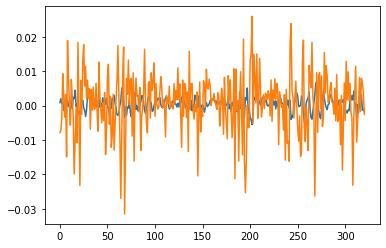

In [11]:
plt.plot(preds)
plt.plot(targets)

In [13]:
preds, targets = modelloaded.Getevaluation(dataloader)

data = df[["Adj Close", "Return_1", "Target"]].copy()
data["Prediction"] = preds

data["Position"] = -1
data.loc[data['Prediction'] > 0,'Position'] = 1

data["Dynamic_PTF_return"] = data["Position"]*data["Target"]
data

,Adj Close,Return_1,Target,Prediction,Position,Dynamic_PTF_return
Date,,,,,,
2014-01-02,142.158234,0.005332,-0.008253,-0.003322,-1,0.008253
2014-01-03,142.400772,-0.008253,0.001705,0.000307,1,0.001705
2014-01-06,141.967697,0.001705,-0.003046,-0.000725,-1,0.003046
2014-01-07,142.903168,-0.003046,0.006568,-0.001836,-1,-0.006568
2014-01-08,142.366135,0.006568,-0.003765,0.002099,1,-0.003765
...,...,...,...,...,...,...
2015-04-07,158.730667,0.007080,-0.000952,0.000880,1,-0.000952
2015-04-08,159.024261,-0.000952,0.001848,0.000319,1,0.001848
2015-04-09,159.602463,0.001848,0.003629,0.000302,1,0.003629


In [27]:
print("Maximum drawdown (%)", (data["Dynamic_PTF_return"].min()-data["Dynamic_PTF_return"].max())/data["Dynamic_PTF_return"].max())

Maximum drawdown (%) -1.868187679087394


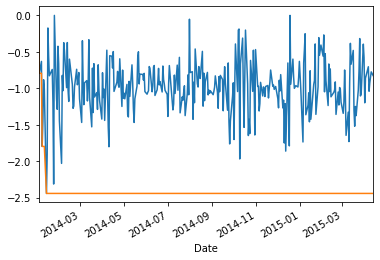

In [45]:
import matplotlib.pyplot as pp

window = len(data)

# Calculate the max drawdown in the past window days for each day in the series.
# Use min_periods=1 if you want to let the first 252 days data have an expanding window
Roll_Max = data['Dynamic_PTF_return'].rolling(window, min_periods=1).max()
Daily_Drawdown = data['Dynamic_PTF_return']/Roll_Max - 1.0

# Next we calculate the minimum (negative) daily drawdown in that window.
# Again, use min_periods=1 if you want to allow the expanding window
Max_Daily_Drawdown = Daily_Drawdown.rolling(window, min_periods=1).min()

# Plot the results
Daily_Drawdown.plot()
Max_Daily_Drawdown.plot() #maximum experienced 252-day drawdown
pp.show()

In [7]:
utils.MDD(data, "Dynamic_PTF_return", len(data))

-2.4403515097068236

In [22]:
Total_df[]

,Open_dia,High_dia,Low_dia,Close_dia,Adj Close_dia,Volume_dia,Open_qqq,High_qqq,Low_qqq,Close_qqq,Adj Close_qqq,Volume_qqq,Open_spy,High_spy,Low_spy,Close_spy,Adj Close_spy,Volume_spy
Date,,,,,,,,,,,,,,,,,,
2011-01-03,116.410004,116.860001,116.360001,116.410004,93.697350,9108900,54.970001,55.689999,54.950001,55.310001,50.170002,90994300,126.709999,127.599998,125.699997,127.050003,105.443665,138725200
2011-01-04,116.709999,116.730003,116.110001,116.639999,93.882401,9775600,55.509998,55.549999,54.919998,55.270000,50.133709,43851500,127.330002,127.370003,126.190002,126.980003,105.385559,137409700
2011-01-05,116.459999,117.190002,116.300003,117.040001,94.204399,7567800,55.099998,55.759998,55.070000,55.740002,50.560024,43787400,126.580002,127.720001,126.459999,127.639999,105.933296,133975300
2011-01-06,117.139999,117.190002,116.500000,116.779999,93.995064,7161600,55.799999,55.959999,55.680000,55.919998,50.723312,46139600,127.690002,127.830002,127.010002,127.389999,105.725830,122519000
2011-01-07,116.910004,117.099998,115.820000,116.570000,93.826057,9249800,56.020000,56.049999,55.320000,55.869999,50.677952,72261700,127.559998,127.769997,126.150002,127.139999,105.518341,156034600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-04-07,178.770004,179.580002,178.419998,178.419998,158.730667,6011600,105.919998,106.699997,105.800003,105.800003,100.975021,19379400,207.860001,208.759995,207.240005,207.279999,187.571274,81236300
2015-04-08,178.600006,179.559998,177.960007,178.750000,159.024261,4738500,105.839996,106.790001,105.830002,106.639999,101.776711,25866900,207.550003,208.509995,207.080002,207.979996,188.204712,89351900
2015-04-09,178.660004,179.630005,177.979996,179.399994,159.602463,4483800,106.589996,107.349998,106.230003,107.309998,102.416145,23114700,207.779999,209.179993,207.190002,208.899994,189.037262,85548900
